# Monomial gamma HMC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.functionaltests.monomial_gamma_hamiltonian_mcmc as mg

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.two_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_2d_gaussian.csv")

2 minutes, 48 seconds


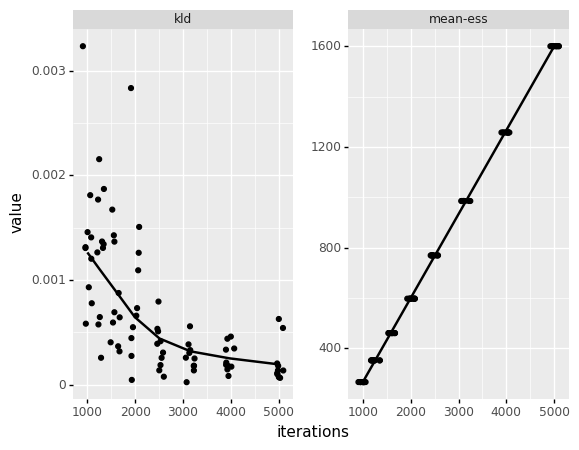

<ggplot: (8730335983038)>

In [3]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

Show example run results.

Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.


/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:02.5
1     84     0.333     0.333     0.333     0.333      0:02.5
2     164    0.5       0.5       0.5       0.5        0:02.5
3     244    0.6       0.6       0.6       0.6        0:02.5
20    1604   0.909     0.909     0.864     0.909      0:02.6
40    3204   0.952381  0.952381  0.905     0.952381   0:02.7
60    4804   0.968     0.968     0.935     0.968      0:02.8
80    6404   0.976     0.976     0.951     0.976      0:02.9
100   8004   0.98      0.98      0.961     0.98       0:03.0
120   9604   0.984     0.984     0.967     0.984      0:03.1
140   11204  0.986     0.986     0.971831  0.986      0:03.2
160   12804  0.988     0.988     0.975     0.988      0:03.3
180   14404  0.989011  0.989011  0.978022  0.989011   0:03.4
200   16004  0.990099  0.990099  0.980198  0.990099   0:03.4
220   17604  0.990991  0.990991  0.981982  0.990991   0:03.5
240   19204  0.992     0

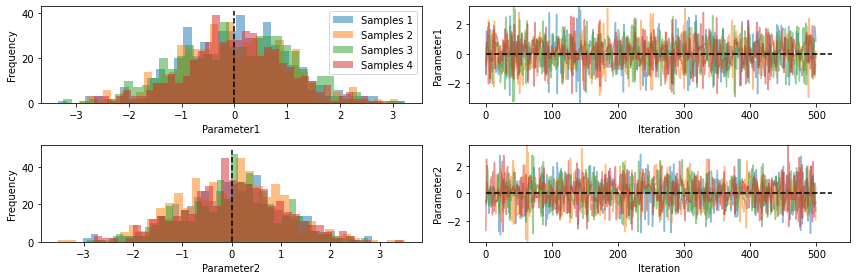

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.01    1.03    -2.06   -0.71  0.02   0.72   2.12     1.00    666.67  93.55
param 2  0.01    1.02    -1.99   -0.66  0.06   0.68   1.99     1.00    666.67  93.55


In [4]:
n_chains = 4
n_iterations = 1000
n_warmup = 500
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(True)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

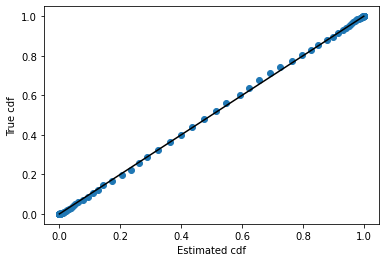

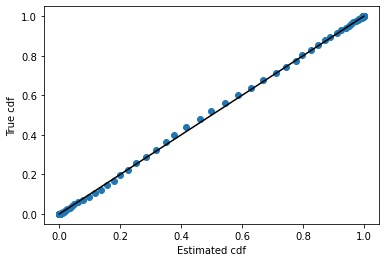

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.correlated_gaussian, parallel)
print(t.format())
df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_correlated_gaussian.csv")

4 minutes, 33 seconds


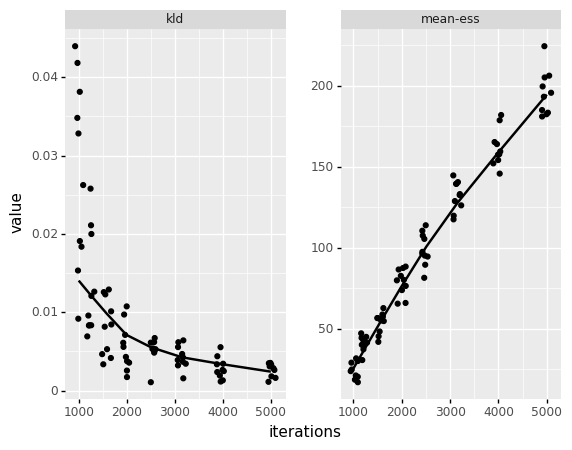

<ggplot: (8730334982937)>

In [7]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results.

/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


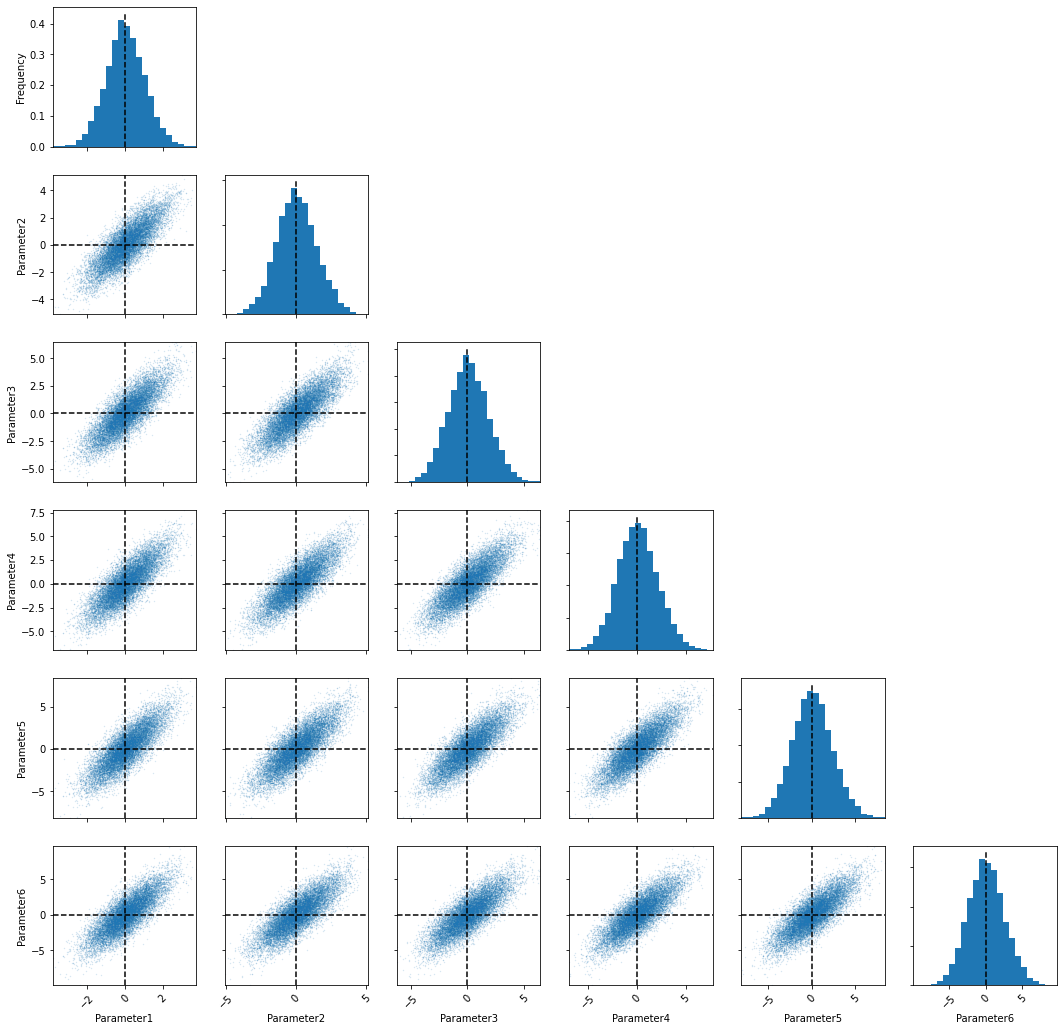

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.04    1.01    -1.92   -0.63  0.03   0.72   2.09     1.01    667.28  22.51
param 2  0.06    1.44    -2.70   -0.92  0.03   1.01   2.96     1.01    651.47  21.97
param 3  0.07    1.75    -3.27   -1.12  0.04   1.24   3.59     1.01    634.25  21.39
param 4  0.10    2.03    -3.78   -1.31  0.07   1.43   4.18     1.01    620.89  20.94
param 5  0.10    2.26    -4.20   -1.42  0.06   1.58   4.68     1.01    616.43  20.79
param 6  0.11    2.50    -4.67   -1.60  0.07   1.76   5.12     1.01    599.66  20.23


In [8]:
n_chains = 4
n_iterations = 4000
n_warmup = 500

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

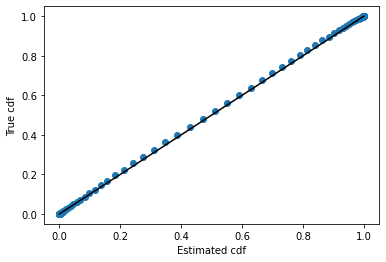

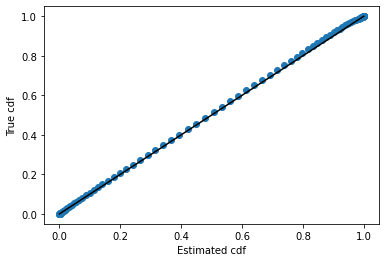

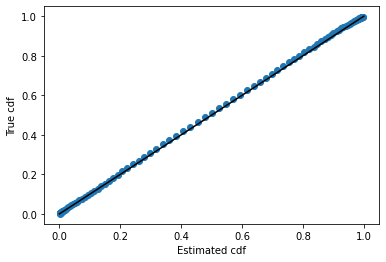

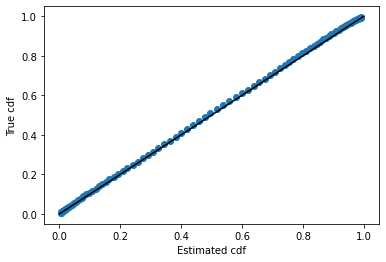

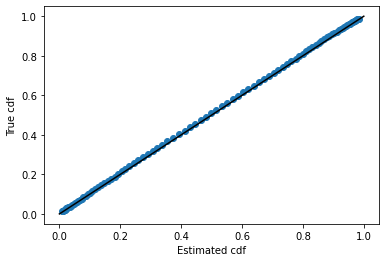

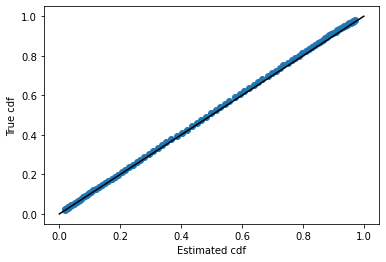

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.banana, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_banana.csv")

3 minutes, 17 seconds


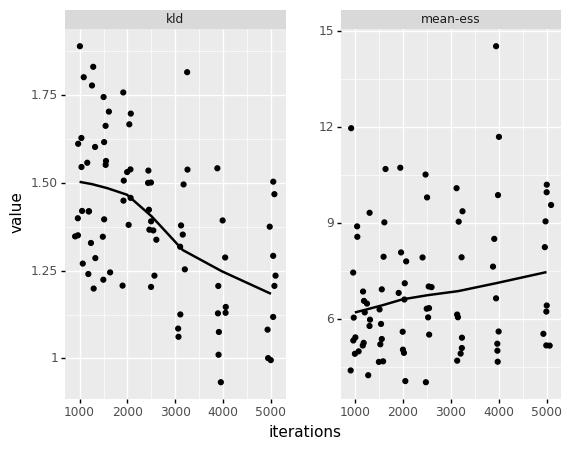

<ggplot: (8730318795478)>

In [11]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The banana is a hard problem with a low ESS. But the KLD is moving in the right direction.

Example run of results.

/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


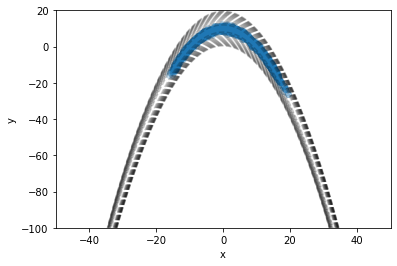

In [12]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.annulus, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_annulus.csv")

6 minutes, 54 seconds


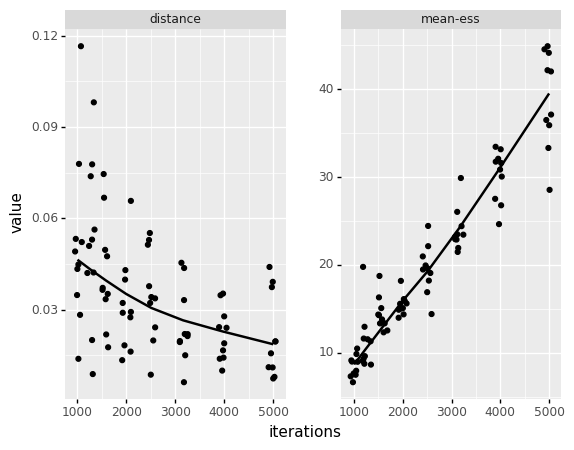

<ggplot: (8730318427911)>

In [14]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The draws trend closer to convergence as the number of iterations increases, although the effective sample size is low here.

Example run.

/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


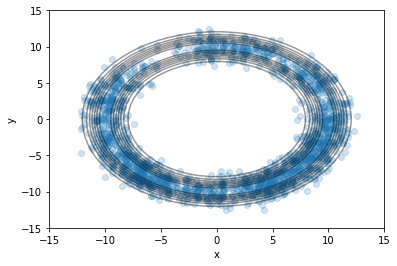

In [15]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Multimodal Gaussian

In [29]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.multimodal_gaussian, parallel)
print(t.format())

8 minutes, 35 seconds


In [31]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_multimodal_gaussian.csv")

# remove high values of kld to see general trend
test1 = test.query('kld < 0.02')
df1 = pd.melt(test1, id_vars=['iterations', 'replicate'])

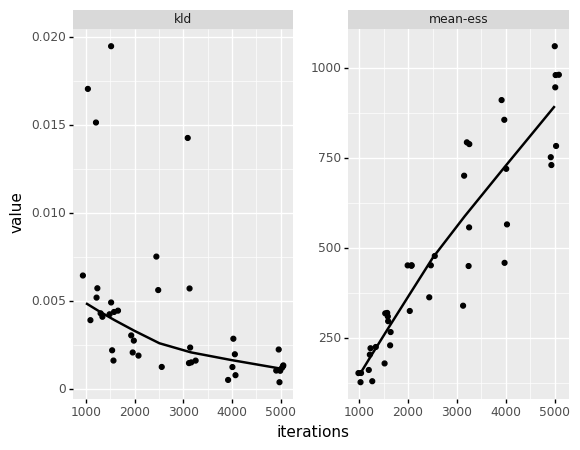

<ggplot: (8730335380767)>

In [32]:
(ggplot(df1, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

With the few outliers removed, the KLD appears to be moving in the correct direction as iterations increase.

/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


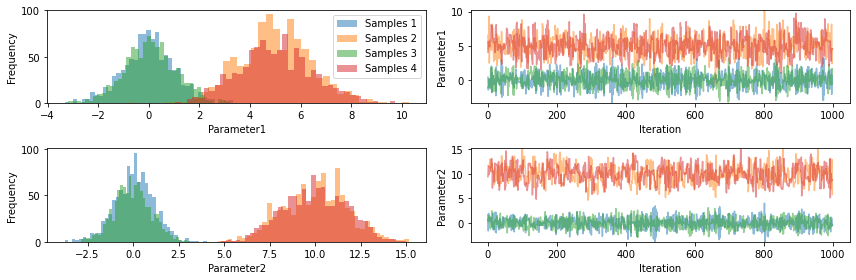

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  2.52    2.78    -1.67   0.03   2.16   4.94   7.44     2.36    1142.55  69.05
param 2  5.02    5.20    -1.64   0.03   4.35   10.06  12.89    3.82    1041.92  62.97


In [27]:
n_chains = 4
n_iterations = 1000
n_warmup = 500

covariances = [[[1, 0], [0, 1]],
               [[2, 0.8], [0.8, 3]],
               [[1, -0.5], [-0.5, 1]]]
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[0, 0], [5, 10], [10, 0]],
                                             covariances=covariances)
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.MonomialGammaHamiltonianMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_leapfrog_step_size(1)
    sampler.set_a(0.5)

chains = controller.run()

pints.plot.trace(chains)

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Clearly this multimodal distribution requires many draws to reach convergence.

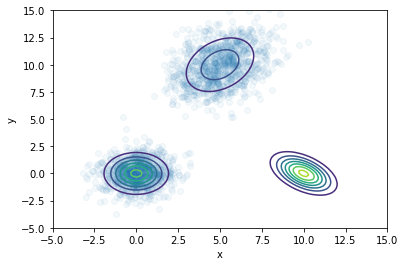

In [28]:
samples = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [20]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.cone, parallel)
print(t.format())
df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_cone.csv")

3 minutes, 7 seconds


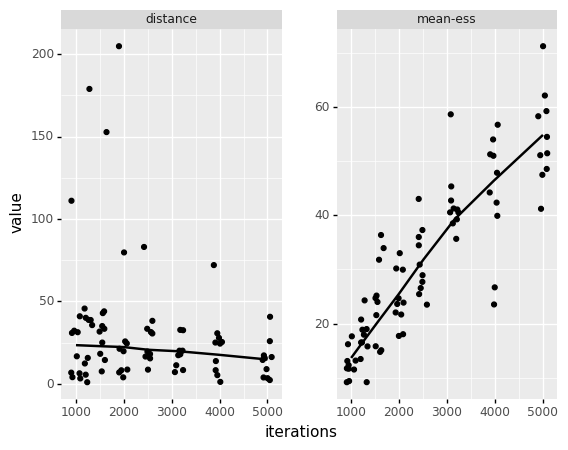

<ggplot: (8730335279014)>

In [21]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Again, the cone problem, with its long tails, is really hard.

Now showing an example run.

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.


/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:267: RuntimeWarning: overflow encountered in exp


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:02.5
1     84     0.333     0.333     0.333     0.333      0:02.5
2     164    0.5       0.5       0.5       0.5        0:02.6
3     244    0.6       0.6       0.6       0.6        0:02.6
20    1604   0.909     0.909     0.909     0.818      0:02.6
40    3204   0.905     0.905     0.929     0.881      0:02.7
60    4804   0.935     0.935     0.935     0.903      0:02.8
80    6404   0.951     0.939     0.939     0.915      0:02.9
100   8004   0.961     0.951     0.941     0.931      0:02.9
120   9604   0.967     0.934     0.942623  0.942623   0:03.0
140   11204  0.971831  0.937     0.951     0.943662   0:03.1
160   12804  0.969     0.944     0.957     0.951      0:03.2
180   14404  0.967033  0.945     0.962     0.951      0:03.3
200   16004  0.970297  0.950495  0.960396  0.955      0:03.3
220   17604  0.972973  0.95      0.963964  0.959      0:03.4
240   19204  0.971     0

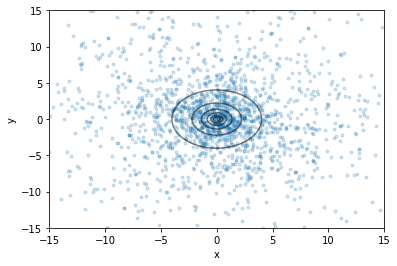

True normed mean = 8.638816024714002
Sample normed mean = 8.483192852749452
True normed var = 65.40423915068341
Sample normed var = 57.11110808964021


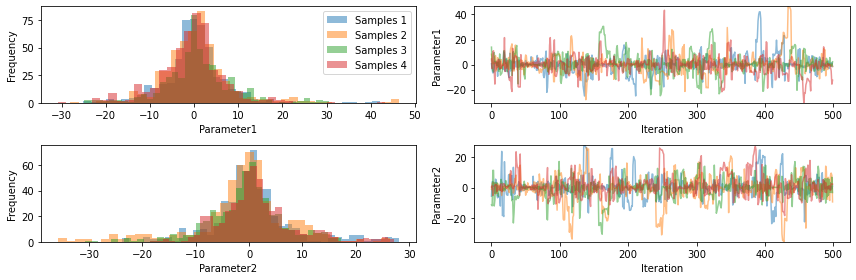

In [22]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.MonomialGammaHamiltonianMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(1000)

# Disable logging
mcmc.set_log_to_screen(True)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(5)
    sampler.set_a(0.5)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[500:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [23]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, mg.high_dim_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])
#df.to_csv("experimental_data/monomial_gamma_hamiltonian_high_dim_gaussian.csv")

10 minutes, 45 seconds


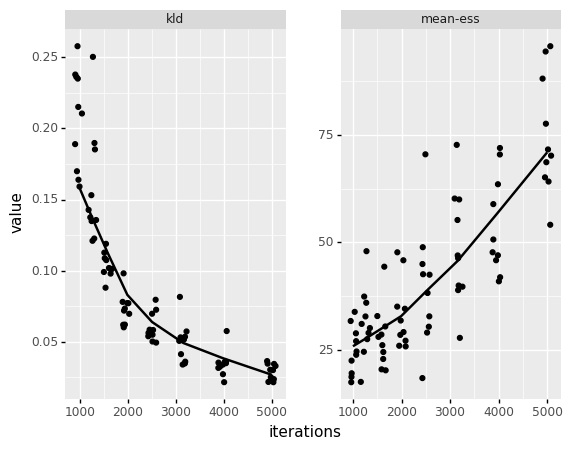

<ggplot: (8730335281586)>

In [24]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)